In [1]:
# venv: /home/teo/venvs/py37-torch-cv
from typing import List, Optional
import sys
from pathlib import Path 
import time

import numpy as np
import torch
import PIL
from PIL import Image
import cv2

from importlib import reload

Array = np.ndarray


PICS_PATH = Path( '/home/teo/Dokumente/Personales/Photos' )
FLD_PATH = Path( '/home/teo/git/pytorch_face_landmark' ) 

sys.path.append( str( FLD_PATH ) ) 

from models.basenet import MobileNet_GDConv
from Retinaface import Retinaface
from common.utils import BBox, drawLandmark_multiple


In [320]:
# the following comes mostly from pytorch_face_landmark/test_batches

if torch.cuda.is_available():
    map_location = lambda storage, loc: storage.cuda()
else:
    map_location = 'cpu'
# %%
print( "map_location: ", map_location )

OUT_SIZE = 224 # for mobile net
MEAN = np.asarray([ 0.485, 0.456, 0.406 ])
STD = np.asarray([ 0.229, 0.224, 0.225 ])

def load_model():
    model = MobileNet_GDConv(136)
    model = torch.nn.DataParallel(model)
            # download model from
            # https://drive.google.com/file/d/1Le5UdpMkKOTRr1sTp4lwkw8263sbgdSe/view?usp=sharing
    checkpoint = torch.load( FLD_PATH / 'checkpoint/mobilenet_224_model_best_gdconv_external.pth.tar',
                            map_location=map_location)

    model.load_state_dict(checkpoint['state_dict'])
    return model

        

map_location:  <function <lambda> at 0x7feefc6ddef0>


In [323]:
# model = load_model() 
# model = model.eval()

In [22]:
list( PICS_PATH.glob('*') )

[PosixPath('/home/teo/Dokumente/Personales/Photos/111NIKON'),
 PosixPath('/home/teo/Dokumente/Personales/Photos/2021-01-10-0934-monis-1.jpg'),
 PosixPath('/home/teo/Dokumente/Personales/Photos/108NIKON'),
 PosixPath('/home/teo/Dokumente/Personales/Photos/105NIKON'),
 PosixPath('/home/teo/Dokumente/Personales/Photos/107NIKON'),
 PosixPath('/home/teo/Dokumente/Personales/Photos/2021-01-10-0934-monis.jpg'),
 PosixPath('/home/teo/Dokumente/Personales/Photos/109NIKON'),
 PosixPath('/home/teo/Dokumente/Personales/Photos/webcam-toy-photo1.jpg'),
 PosixPath('/home/teo/Dokumente/Personales/Photos/110NIKON'),
 PosixPath('/home/teo/Dokumente/Personales/Photos/2021-01-09-0750-teo.jpg'),
 PosixPath('/home/teo/Dokumente/Personales/Photos/106NIKON')]

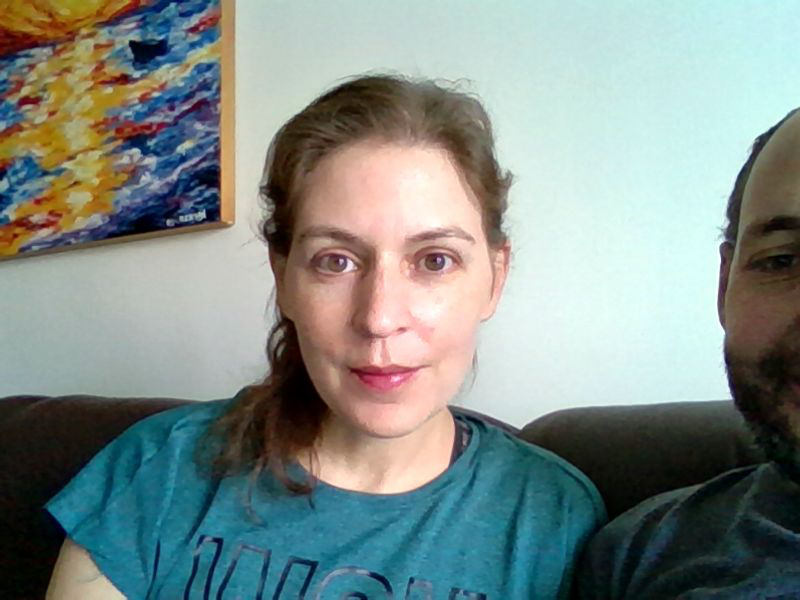

In [2]:
# img0 = PIL.Image.open( str(PICS_PATH / '2021-01-10-0934-monis.jpg') )
# img0 = PIL.Image.open( str(PICS_PATH / '2021-01-09-0750-teo.jpg') )
img0 = 
img = np.asarray( img0 )
img.shape
img0

In [3]:
Retinaface.trained_model = str( FLD_PATH / 'Retinaface/weights/mobilenet0.25_Final.pth' )

In [5]:
import fld
reload( fld )

triangles = fld.TRIANGLES

model = fld.load_model() 
# model.eval()

map_location:  cpu


/home/teo/venvs/py37-torch-fld/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [169]:
type( img0 )

PIL.JpegImagePlugin.JpegImageFile

In [6]:
from dataclasses import dataclass

@dataclass
class ProcessedImage:
    img: Array  # shape: (h, w, c)
    bbox: BBox 
    landmarks: Array
        

In [7]:
def landmarks_1_face( img0: PIL.Image ):
    img = np.asarray( img0 )
    img.shape
    
    retinaface = Retinaface.Retinaface()
    faces = retinaface(img)    

    landmarks, new_bbox = fld.process_1_face(faces[0], img, model )
    
    return ProcessedImage( img, new_bbox, landmarks )


def draw_landmarks(pimg: ProcessedImage) -> PIL.Image:
    img = drawLandmark_multiple(pimg.img, pimg.bbox, pimg.landmarks)
    return Image.fromarray(img)

In [133]:
# img0 = PIL.Image.open( str(PICS_PATH / '2021-01-10-0751-teo.jpg') )
# img0 = PIL.Image.open( str(PICS_PATH / '2021-01-10-0934-monis.jpg') )
img0 = PIL.Image.open( str(PICS_PATH / '2021-01-09-0750-teo.jpg') )

pimg1 = landmarks_1_face( img0 )
# draw_landmarks( pimg1 )

Loading pretrained model from /home/teo/git/pytorch_face_landmark/Retinaface/weights/mobilenet0.25_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300
net forward time: 0.0226
build_bbox: img_shape=(442, 470, 3)
torch.float32
Time: 0.434324s.


In [131]:
# img2_raw = PIL.Image.open( str(PICS_PATH / '2021-01-10-0934-monis.jpg') )
img2_raw = PIL.Image.open( PICS_PATH / 'tom-cruise-2.jpg')

pimg2 = landmarks_1_face( img2_raw )
# draw_landmarks( pimg2 )

Loading pretrained model from /home/teo/git/pytorch_face_landmark/Retinaface/weights/mobilenet0.25_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300
net forward time: 0.1369
build_bbox: img_shape=(1080, 1080, 3)
torch.float32
Time: 0.430054s.


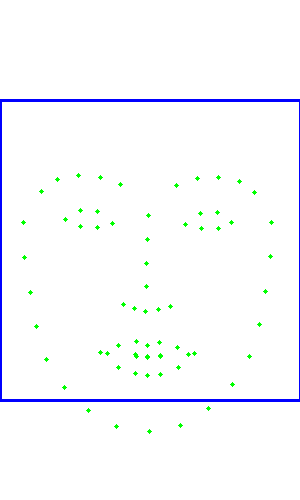

In [11]:
# landmarks in coordinates relative to bbox
lm_p1 = pimg1.bbox.projectLandmark( pimg1.landmarks )
lm_p2 = pimg2.bbox.projectLandmark( pimg2.landmarks )

lambdah = 0.5
lm_pc = (1 - lambdah) * lm_p1 + lambdah * lm_p2
lm_pc

out_w, out_h = (300, 500) 
img_c = 255 * np.ones( (out_h, out_w, 3),  dtype=np.uint8 ) 
bbox = BBox( [0, out_w, 100, 100 + out_w ])  

pimg_c = ProcessedImage( img_c, bbox, bbox.reprojectLandmark( lm_pc) )

draw_landmarks( pimg_c ) 

In [135]:
# pimg_c.landmarks

In [275]:
class BariCalc1:
    
    def __init__( self, triangles: List[List[int]], lm_c: Array ):
        self.triangles = np.array( triangles )
        self.lm_c = lm_c 
        self.find_tri_cnt = 0

    def coords_1_triangle( self, x: int, y: int, triangle_idx: int ) -> Array:
        triangle = triangles[triangle_idx]
    
        x1, y1 = lm_c[ triangle[0] ]
        x2, y2 = lm_c[ triangle[1] ]
        x3, y3 = lm_c[ triangle[2] ]
        
        dx = x - x1
        dy = y - y1
        dx2 = x2 - x1
        dy2 = y2 - y1
        dx3 = x3 - x1
        dy3 = y3 - y1
        
        det = (dy2 * dx3 - dx2 * dy3)
        b2 = (+ dy * dx3 - dx * dy3) / det
        b3 = (- dy * dx2 + dx * dy2) / det
        b1 = 1.0 - b2 - b3
        
        return np.array([b1, b2, b3])
    
    def find_triangle( self, x: int, y: int ) -> Optional[int]: 
        self.find_tri_cnt += 1
        for t_idx in range( len(self.triangles) ):
            b1, b2, b3 = self.coords_1_triangle( x, y, t_idx )
            if b1 >= 0 and b2 >= 0 and b3 >= 0:
                return t_idx
        
        return None
    
    def find_triangle_hint( self, x: int, y: int, triangle_idx: int ) -> Optional[int]:
        if triangle_idx is None:
            return self.find_triangle( x, y )
        else:
            b1, b2, b3 = self.coords_1_triangle( x, y, triangle_idx )
            if b1 >= 0 and b2 >= 0 and b3 >= 0:
                return triangle_idx
            else:
                return self.find_triangle( x, y )

# lm_c = pimg_c.landmarks

bcalc1 = BariCalc1( fld.TRIANGLES, lm_c )

triangle_idx = 4
triangle = triangles[triangle_idx]
b1, b2, b3 = bcalc1.coords_1_triangle( 100.0, 103.0, triangle_idx )

b1 * lm_c[ triangle[0] ] + b2 * lm_c[ triangle[1] ] + b3 * lm_c[ triangle[2] ]
       
bcalc1.find_triangle( 207, 405 )

101

In [ ]:

triangle_idx = None

not_none_cnt = 0 
for row in range(out_h):
    print( row )
    for col in range(out_w):
            triangle_idx = bcalc.find_triangle_hint( x=col, y=row, triangle_idx=triangle_idx )
            if triangle_idx is not None:
                not_none_cnt +=1 

In [70]:
            
class BariCalc2:
    
    def __init__( self, triangles: List[List[int]], lm_c: Array, dim: int ):
        self.triangles = np.array( triangles )
        self.lm_c = lm_c 
        self.find_tri_cnt = 0
        
        self.dim = dim
        self.num_tri = len( triangles )
        p1 = np.array( [lm_c[triangle[0]] for triangle in self.triangles] )
        p2 = np.array( [lm_c[triangle[1]] for triangle in self.triangles] )
        p3 = np.array( [lm_c[triangle[2]] for triangle in self.triangles] )
        
        self.x1 = np.tile( p1[:, [0]], (1, dim) )
        self.y1 = np.tile( p1[:, [1]], (1, dim) )
        self.dx2 = np.tile( p2[:, [0]] - p1[:, [0]], (1, dim) ) 
        self.dy2 = np.tile( p2[:, [1]] - p1[:, [1]], (1, dim) ) 
        self.dx3 = np.tile( p3[:, [0]] - p1[:, [0]], (1, dim) ) 
        self.dy3 = np.tile( p3[:, [1]] - p1[:, [1]], (1, dim) ) 
        
        # print( "p1: ", p1.shape )  # will be (self.num_tri, 2)
        # print( "x1, y1: ", self.x1.shape, self.y1.shape )  # will be (self.num_tri, 2)
        
        
    def coords_triangles( self, x: Array, y: Array ) -> Array:
        
        assert x.shape == (1, self.dim)
        assert y.shape == (1, self.dim)
        dx = np.tile( x, (self.num_tri, 1 ) ) - self.x1
        dy = np.tile( y, (self.num_tri, 1 ) ) - self.y1
    
        det = (self.dy2 * self.dx3 - self.dx2 * self.dy3)
        b2 = (+ dy * self.dx3 - dx * self.dy3) / det
        b3 = (- dy * self.dx2 + dx * self.dy2) / det
        b1 = 1.0 - b2 - b3
        
        return np.array([b1, b2, b3]).transpose( (2, 1, 0) )
    
    def triangle_indices_coords( self, x: Array, y: Array ):
        b_coords = self.coords_triangles( x, y )
        all_pos = (b_coords[:, :, 0] >= 0.) & (b_coords[:, :, 1] >= 0.) & ( b_coords[:, :, 2] >= 0)
        
        non_zero = np.nonzero(all_pos)
        row_indices = non_zero[0]
        t_indices = non_zero[1]
        b_coords_ret = b_coords[ non_zero ] 
        
        return row_indices, t_indices, b_coords_ret

In [52]:
row_indices.shape, t_indices.shape, b_coords_ret.shape

((179,), (179,), (179, 3))

In [64]:

def get_triangle_vertex_coords( landmarks, vertex_idx ):
    return np.array( [ landmarks[ triangle[vertex_idx] ] for triangle in fld.TRIANGLES ] )


class ImageCombiner:
    
    def __init__(self, pimg1: ProcessedImage, pimg2: ProcessedImage, lambdah: float):
        self.img1 = pimg1.img
        self.img2 = pimg2.img
        self.lambdah = lambdah 

        self.p10 = get_triangle_vertex_coords( pimg1.landmarks, 0 )
        self.p11 = get_triangle_vertex_coords( pimg1.landmarks, 1 )
        self.p12 = get_triangle_vertex_coords( pimg1.landmarks, 2 )
        
        self.p20 = get_triangle_vertex_coords( pimg2.landmarks, 0 )
        self.p21 = get_triangle_vertex_coords( pimg2.landmarks, 1 )
        self.p22 = get_triangle_vertex_coords( pimg2.landmarks, 2 )
        
    
    def combine( self, b: Array, t_indices: Array ):
        
        # coordinates of points with baricentric coordinates b relative to triangles t_indices in img 1
        coords1 = b[:, [0]] * self.p10[t_indices] + b[:, [1]] * self.p11[t_indices] + b[:, [2]] * self.p12[t_indices]
        coords1 = coords1.astype(np.int32)
        
        
        # coordinates of points with baricentric coordinates b relative to triangles t_indices in img 2
        coords2 = b[:, [0]] * self.p20[t_indices] + b[:, [1]] * self.p21[t_indices] + b[:, [2]] * self.p22[t_indices]
        coords2 = coords2.astype(np.int32)

        # extract pixel values from img1 at coords1
        pixels1 = self.img1[ (coords1[:, 1], coords1[:, 0]) ]
        pixels2 = self.img2[ (coords2[:, 1], coords2[:, 0]) ]
        
        pixelsc = ((1.0 - self.lambdah) * pixels1 + self.lambdah * pixels2).astype(np.uint8) 
        
        return pixelsc

In [124]:
print( sorted( [0.48, 0.46, 0.44, 0.42, 0.4, 0.38, 0.36, 0.34, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.0], key=lambda x: x ) )

[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48]


In [127]:
def gen_gif( out_fpath: Path, lambdas: List[float] = None ):
    if lambdas is None:
        lambdas =  [ 0.5, 0.54, 0.56, 0.58, 0.60, 0.62, 0.64, 0.66, 0.70, 0.75, 0.80, 0.85, 0.9, 0.95, 1.0,
                     0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.66, 0.64, 0.62, 0.6, 0.58, 0.56, 0.54, 0.5,
                     0.48, 0.46, 0.44, 0.42, 0.4, 0.38, 0.36, 0.34, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.0,
                     0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5 ]
    imgs = []
    for i, lambdah in enumerate(lambdas):
        img = combine(pimg1, pimg2, lambdah)
        print( f"{i:2d}/{len(lambdas)}", "\r" )
        imgs.append( img )
        
    head, *tail = imgs
    
    head.save( fp=out_fpath, format='GIF', append_images=imgs,
               save_all=True, duration=200, loop=1) 
        
gen_gif( PICS_PATH / 'c_teo_monis.gif' ) 

 0/59 
 1/59 
 2/59 
 3/59 
 4/59 
 5/59 
 6/59 
 7/59 
 8/59 
 9/59 
10/59 
11/59 
12/59 
13/59 
14/59 
15/59 
16/59 
17/59 
18/59 
19/59 
20/59 
21/59 
22/59 
23/59 
24/59 
25/59 
26/59 
27/59 
28/59 
29/59 
30/59 
31/59 
32/59 
33/59 
34/59 
35/59 
36/59 
37/59 
38/59 
39/59 
40/59 
41/59 
42/59 
43/59 
44/59 
45/59 
46/59 
47/59 
48/59 
49/59 
50/59 
51/59 
52/59 
53/59 
54/59 
55/59 
56/59 
57/59 
58/59 


00:


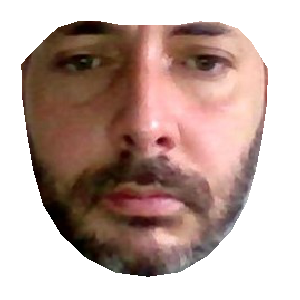

10:


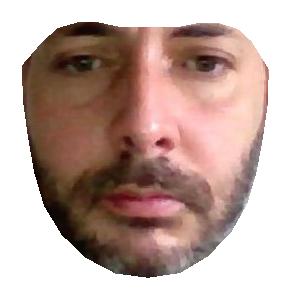

20:


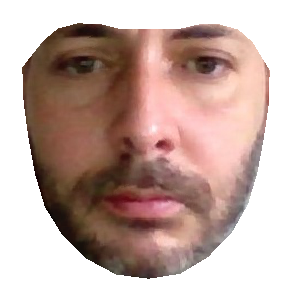

30:


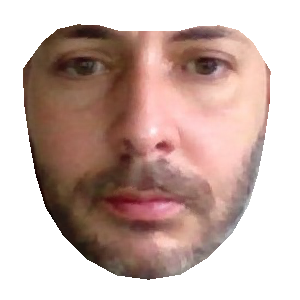

34:


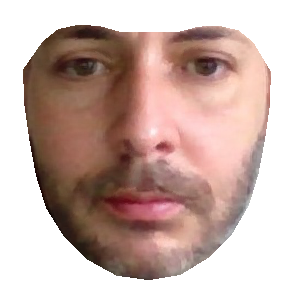

36:


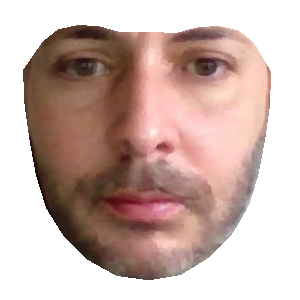

38:


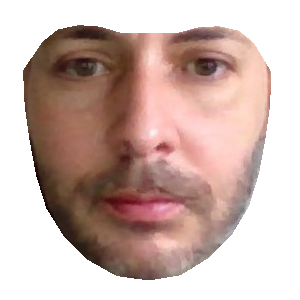

40:


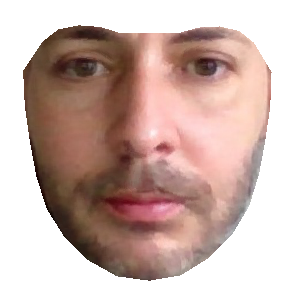

42:


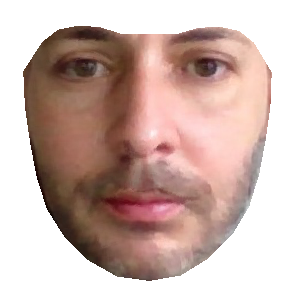

44:


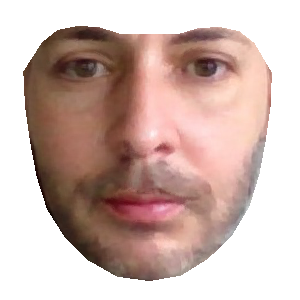

46:


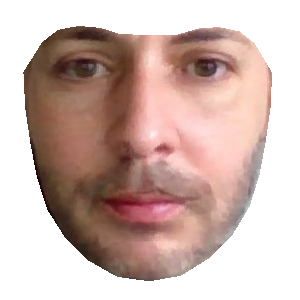

48:


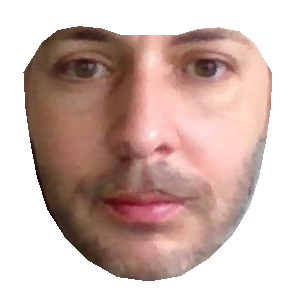

50:


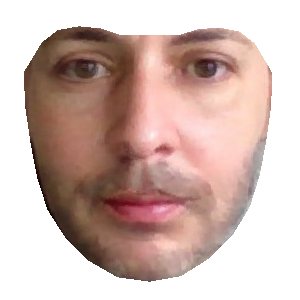

54:


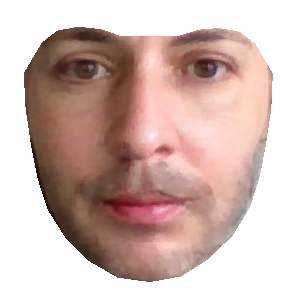

56:


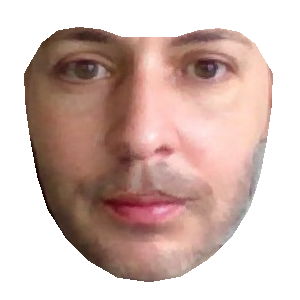

57:


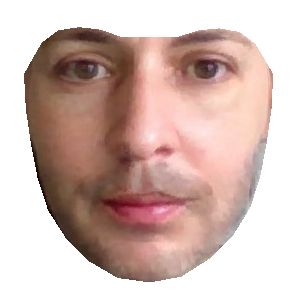

60:


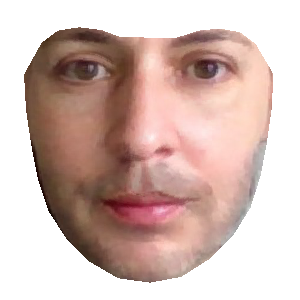

62:


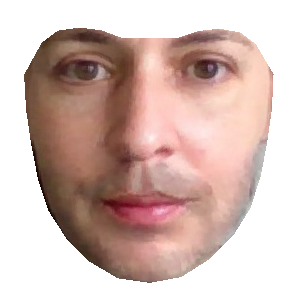

64:


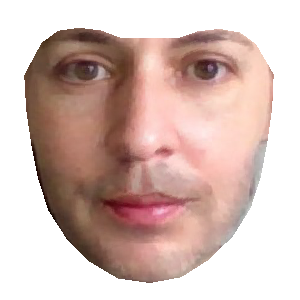

66:


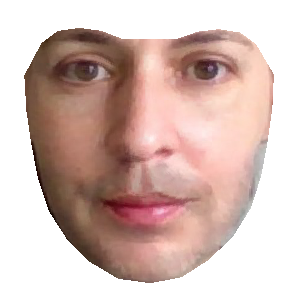

70:


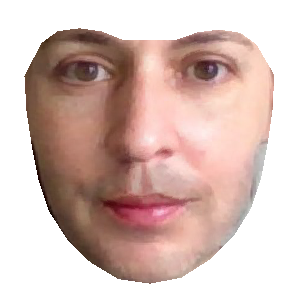

80:


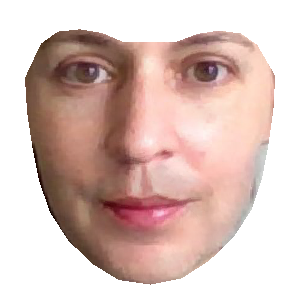

90:


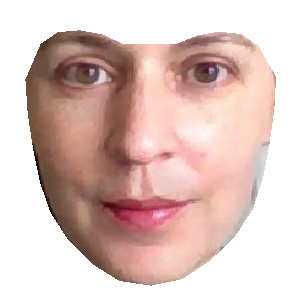

100:


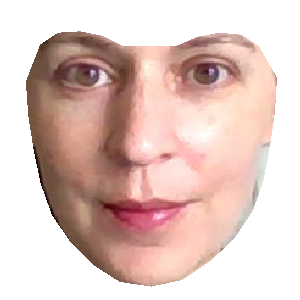

In [109]:
def combine( pimg1: ProcessedImage, pimg2: ProcessedImage, lambdah: float ):
    lm_p1 = pimg1.bbox.projectLandmark( pimg1.landmarks )
    lm_p2 = pimg2.bbox.projectLandmark( pimg2.landmarks )

    lm_pc = (1 - lambdah) * lm_p1 + lambdah * lm_p2

    out_w, out_h = (300, 300) 
    img_c = 255 * np.ones( (out_h, out_w, 3),  dtype=np.uint8 ) 
    bbox = BBox( [0, out_w, -50, -50 + out_w ])  

    lm_c = bbox.reprojectLandmark(lm_pc)
    
    img_combiner = ImageCombiner( pimg1, pimg2, lambdah )
    bcalc2 = BariCalc2( fld.TRIANGLES, lm_c, dim=out_h )

    def do_col( col ):
        x = col * np.ones( (1, out_h) )
        y = np.arange( out_h ).reshape( (1, out_h))

        row_indices, t_indices, b = bcalc2.triangle_indices_coords( x, y ) 
        pixelsc = img_combiner.combine( b, t_indices )

        img_c[ (row_indices, col) ] = pixelsc
        
    t1 = time.perf_counter()

    for col in range(out_w):
        do_col(col)
        
    t2 = time.perf_counter()
    # print( t2 - t1 )

    return PIL.Image.fromarray( img_c )


for lambdah in [0.0, 0.1, 0.2, 0.3, 0.34, 0.36, 0.38, 0.40, 0.42, 0.44, 0.46, 0.48, 
                0.5, 0.54, 0.56, 0.58, 0.60, 0.62, 0.64, 0.66, 0.70, 0.80, 0.9, 1.0]:
    
    img = combine( pimg1, pimg2, lambdah)
    img.save( PICS_PATH / f"c_{int(lambdah * 100) :02d}.png")
    print( f"{int(lambdah * 100) :02d}:" )
    
    display(img)

In [ ]:
img1_raw = PIL.Image.open( str(PICS_PATH / '2021-01-09-0750-teo.jpg') )
pimg1 = landmarks_1_face( img1_raw )

img2_raw = PIL.Image.open( PICS_PATH / 'maluma-1.jpg')
pimg2 = landmarks_1_face( img2_raw )


import face_comb as fcomb
reload( fcomb )

fcomb.gen_transition( pimg1, pimg2, PICS_PATH / 'teo_maluma' )

In [147]:
reload( fcomb )
fcomb.gen_animation( pimg1, pimg2, PICS_PATH / 'teo_maluma.webp')

format: WEBP


In [145]:
from PIL import Image

In [146]:
Image.SAVE

{'BMP': <function PIL.BmpImagePlugin._save(im, fp, filename, bitmap_header=True)>,
 'DIB': <function PIL.BmpImagePlugin._dib_save(im, fp, filename)>,
 'GIF': <function PIL.GifImagePlugin._save(im, fp, filename, save_all=False)>,
 'TIFF': <function PIL.TiffImagePlugin._save(im, fp, filename)>,
 'JPEG': <function PIL.JpegImagePlugin._save(im, fp, filename)>,
 'PPM': <function PIL.PpmImagePlugin._save(im, fp, filename)>,
 'PNG': <function PIL.PngImagePlugin._save(im, fp, filename, chunk=<function putchunk at 0x7f6dec99b830>, save_all=False)>,
 'BUFR': <function PIL.BufrStubImagePlugin._save(im, fp, filename)>,
 'PCX': <function PIL.PcxImagePlugin._save(im, fp, filename)>,
 'EPS': <function PIL.EpsImagePlugin._save(im, fp, filename, eps=1)>,
 'FITS': <function PIL.FitsStubImagePlugin._save(im, fp, filename)>,
 'GRIB': <function PIL.GribStubImagePlugin._save(im, fp, filename)>,
 'HDF5': <function PIL.Hdf5StubImagePlugin._save(im, fp, filename)>,
 'JPEG2000': <function PIL.Jpeg2KImagePlugin.

In [309]:
np.nonzero( all_pos )

(array([184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196,
        197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209,
        210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,
        223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235,
        236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248,
        249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261,
        262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274,
        275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287,
        288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300,
        301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313,
        314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326,
        327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339,
        340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352,
        353, 354, 355, 356, 357, 358, 359, 360, 361

In [288]:
bcalc2.lm_c.dtype

dtype('float64')

In [284]:
 
x = np.array([1,2,3])

x.reshape(3,1)


array([[1],
       [2],
       [3]])

In [272]:
out_w * out_h 

150000

In [271]:
not_none_cnt

51483

In [40]:
from PIL.ImageDraw import Draw

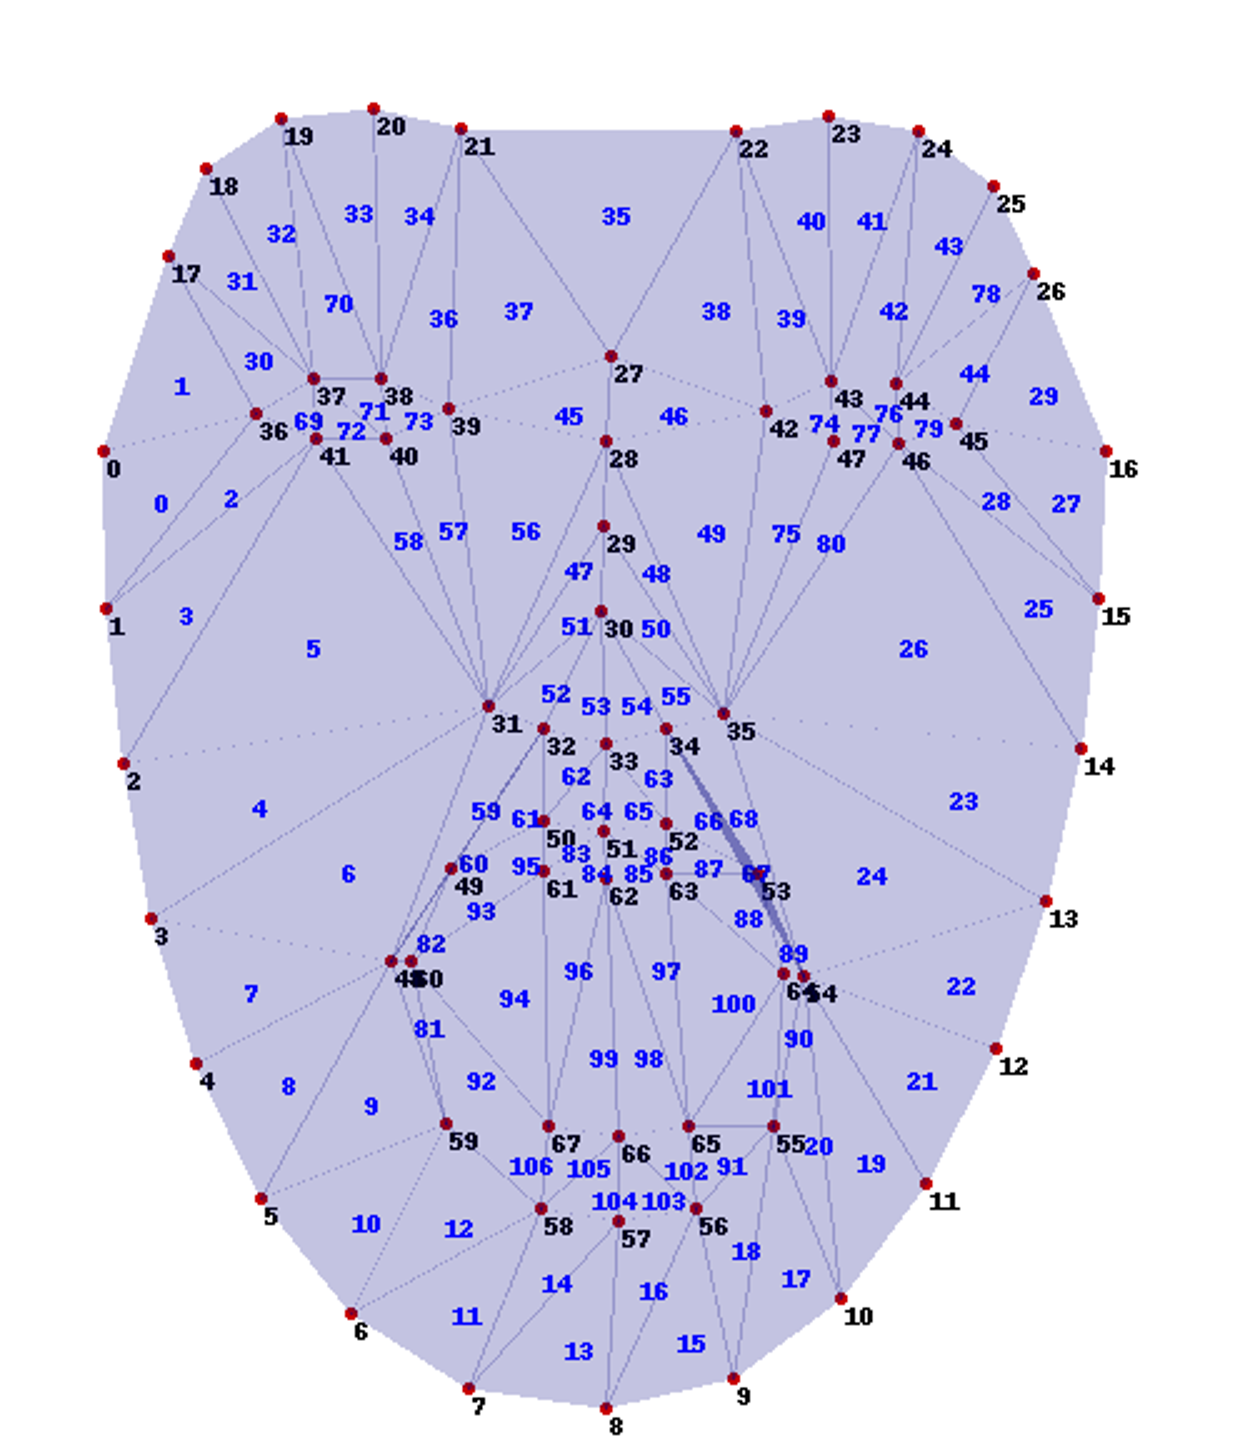

In [168]:
landmark_u = new_bbox.projectLandmark( landmark )

canvas = Image.fromarray( 255 * np.ones( (580, 500, 3), dtype=np.uint8 ) )
landmark_c = fld.BBox( [0, 500, 0, 500] ).reprojectLandmark( landmark_u )

# canvas = Image.fromarray( 255 * np.ones( (450, 900, 3), dtype=np.uint8 ) )
# landmark_c = fld.BBox( [-300, 900, -700, 500] ).reprojectLandmark( landmark_u )


draw = Draw(canvas, mode='RGBA')

offset = 0 
# offset = 48

for i, row in enumerate(landmark_c[offset:]):
    draw.ellipse( [(row[0] - 2, row[1]- 2), ( row[0] + 2, row[1] + 2) ],  fill=(200, 0,0) ) 
    draw.text( (row[0]+2, row[1]+2), f"{i+offset}", fill=(0, 0, 0) )
    

def draw_triangle( draw, triangle, lm_c, label ): 
    i0, i1, i2 = triangle[0], triangle[1], triangle[2]
    
    if not( i0 >= offset and i1 >= offset and i2 >= offset ):
        return
    
    draw.polygon( [ tuple(lm_c[i0]), tuple(lm_c[i1]), tuple(lm_c[i2]) ], 
                 fill=(0, 0, 128, 60)  )
    
    centroid = (lm_c[i0] + lm_c[i1] + lm_c[i2]) / 3.0 
    draw.text( tuple(centroid), label, fill=(0,0,255) )
    
for i, triangle in enumerate(triangles):
    draw_triangle( draw, triangle, landmark_c, f"{i}" )

#canvas.resize( (int(900 * 2.5), int(450 * 2.5) ) )
canvas.resize( (int(500 * 2.5), int(580 * 2.5) ) )

In [167]:
triangles = sorted( triangles )

In [164]:
triangles = [
    [ 60, 59, 67],
    [ 67, 59, 58 ],
    [ 67, 58, 66],
    [ 66, 58, 57],
    [ 66, 57, 56],
    [ 66, 56, 65],
    [ 48, 60, 49],
    [ 60, 61, 49],
    [ 61, 50, 49],
    [ 50, 61, 51],
    [ 51, 61, 62],
    [ 51, 62, 63],
    [ 51, 63, 52],
    # [ 52, 63, 53],
    [ 53, 64, 54],
    [ 53, 63, 64],
    [ 60, 67, 61],
    [ 61, 67, 62],
    [ 62, 67, 66],
    [ 62, 66, 65],
    [ 62, 65, 63],
    [ 64, 63, 65],
    [ 48, 59, 60],
    [ 54, 64, 55],
    [64, 65, 55],
    [ 55, 65, 56 ],
    # []
    [ 34, 52, 53 ],
    [ 34, 54, 35 ],
    [ 34, 53, 54 ],
    [ 36, 41, 37 ],
    [ 37, 41, 40 ],
    [ 37, 40, 38 ],
    [ 38, 40, 39 ],
    [ 28, 29, 31 ],
    [ 31, 40, 41 ],
    [ 31, 39, 40 ],
    [ 31, 28, 39 ],
    [ 30, 31, 32 ],
    [ 30, 32, 33 ],
    [ 30, 33, 34 ],
    [ 30, 34, 35 ],
    [ 31, 48, 32 ],
    [ 32, 48, 49 ],
    [ 32, 49, 50 ],
    [ 32, 50, 33 ],
    [ 33, 50, 51 ],
    [ 33, 51, 52 ],
    [ 33, 34, 52 ],
    [ 52, 63, 53 ],
    # [ , , ],
    [ 0, 36, 17],
    [ 17, 36, 37 ],
    [ 17, 37, 18 ],
    [ 18, 37, 19 ],
    [ 37, 38, 19 ],
    [ 19, 38, 20 ],
    [ 20, 38, 21 ],
    [ 21, 38, 39 ],
    [ 21, 39, 27 ],
    [ 21, 22, 27 ],
    [ 27, 39, 28 ],
    [ 29, 31, 30],
    [ 22, 43, 42],[ 22,27 ,42 ],[27 ,42 , 28 ],[ 28,29 ,35 ],[29,30,35],
    [ 28, 35 , 42],
    [ 42, 47, 35],
    [ 47, 46, 35],
    [ 42, 43, 47],
    [ 43, 47, 46],
    [ 43, 46, 44],
    [ 44, 46, 45],
    # [ , , ],[ , , ],
    [ 23,22 ,43 ],
    [ 24,23,43 ],
    [ 24, 43,44 ],
    [ 25, 24, 44],
    [ 44, 26, 25 ],
    [ 26,44, 45],
    [ 16,26, 45],
    [ 15, 16, 45],
    [ 15, 46, 45 ],
    [ 14, 15, 46],
    [ 14, 35, 46],
    [ 0, 1 , 36 ],
    [ 1, 36, 41 ],
    [ 1, 41, 2 ],
    [ 2, 41, 31 ],
    [ 2, 31, 3],
    [ 3, 31, 48 ],
    [ 3, 48, 4 ],
    [ 4, 48, 5 ],
    [ 5, 48, 59 ],
    [ 5, 59, 6 ],
    [ 6, 59, 58 ],
    [ 6, 58 , 7 ],
    [ 7, 58, 57 ],
    [ 7, 57, 8 ],
    [ 8, 57, 56 ],
    [ 8, 56, 9],
    [ 9, 56, 55 ],
    [ 9, 55, 10],
    [ 10, 55 ,54 ],
    [ 10, 11, 54 ],
    [ 11, 54 ,12 ],
    [ 12, 54, 13 ],
    [ 13, 35, 54 ],
    [ 13, 35, 14 ],
    # [ , , ],
    # [ , , ],
    
]

In [156]:

len( triangles )

107